Environment Setup & Dependencies

In [ ]:
!pip install transformers datasets accelerate bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset
import numpy as np
import re


Dataset Preparation

In [ ]:
dataset = load_dataset("squad")
print(dataset)
print(dataset["train"][0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})
{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome

Model Access & API Client Initialization

In [ ]:
import os
os.environ["HF_TOKEN"] = ""


In [ ]:
from openai import OpenAI

client = OpenAI(
    base_url="https://router.huggingface.co/v1",
    api_key=os.environ["HF_TOKEN"],
)


Prompt Engineering

In [ ]:
zero_shot_prompt = """
Answer the question based only on the context.

Context: {context}
Question: {question}
Answer:
"""

few_shot_prompt = """
You are a QA assistant. Here are examples:

Context: The capital of France is Paris.
Question: What is the capital of France?
Answer: Paris

Context: The largest planet in our solar system is Jupiter.
Question: What is the largest planet?
Answer: Jupiter

Now answer this:

Context: {context}
Question: {question}
Answer:
"""


Answer Generation Function

In [ ]:
def get_answer_api(prompt, model="meta-llama/Meta-Llama-3-8B-Instruct:novita", max_tokens=64):
    completion = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=max_tokens
    )
    return completion.choices[0].message.content.strip()


In [ ]:
print(get_answer_api("What is the capital of France?"))



The capital of France is Paris.


Evaluation Metrics Implementation

In [ ]:
import re

def normalize_text(s):
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", "", s)
    return s.strip()

def compute_em_f1(pred, gold):
    pred, gold = normalize_text(pred), normalize_text(gold)
    em = int(pred == gold)
    pred_tokens, gold_tokens = pred.split(), gold.split()
    common = set(pred_tokens) & set(gold_tokens)
    if not common:
        return em, 0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(gold_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return em, f1


Experimental Evaluation Loop

In [ ]:
from datasets import load_dataset

dataset = load_dataset("squad", split="validation[:10]")
results = {"zero_shot": [], "few_shot": []}

for ex in dataset:
    context, question, gold = ex["context"], ex["question"], ex["answers"]["text"][0]

    # Zero-Shot
    zs_prompt = zero_shot_prompt.format(context=context, question=question)
    zs_ans = get_answer_api(zs_prompt)
    em, f1 = compute_em_f1(zs_ans, gold)
    results["zero_shot"].append((em, f1))

    # Few-Shot
    fs_prompt = few_shot_prompt.format(context=context, question=question)
    fs_ans = get_answer_api(fs_prompt)
    em, f1 = compute_em_f1(fs_ans, gold)
    results["few_shot"].append((em, f1))


Results Aggregation

In [ ]:
import numpy as np

def avg_score(results):
    ems, f1s = zip(*results)
    return {"EM": np.mean(ems), "F1": np.mean(f1s)}

print("Zero-Shot:", avg_score(results["zero_shot"]))
print("Few-Shot:", avg_score(results["few_shot"]))


Zero-Shot: {'EM': np.float64(0.2), 'F1': np.float64(0.4844444444444445)}
Few-Shot: {'EM': np.float64(0.7), 'F1': np.float64(0.8177777777777777)}


Performance Visualization

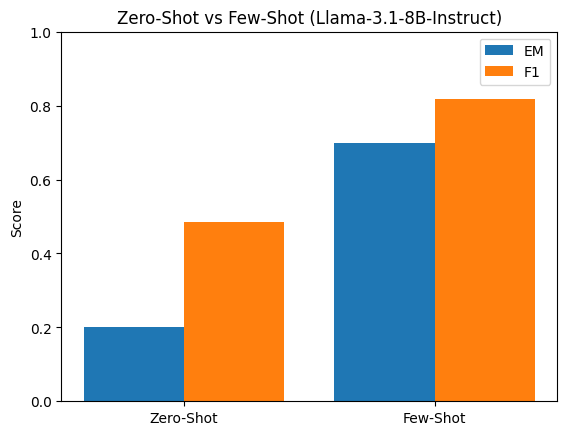

In [ ]:
import matplotlib.pyplot as plt

scores = {
    "Zero-Shot": {"EM": 0.2, "F1": 0.484},
    "Few-Shot": {"EM": 0.7, "F1": 0.818}
}

labels = list(scores.keys())
em_scores = [scores[m]["EM"] for m in labels]
f1_scores = [scores[m]["F1"] for m in labels]

x = range(len(labels))
plt.bar(x, em_scores, width=0.4, label="EM", align="center")
plt.bar([i+0.4 for i in x], f1_scores, width=0.4, label="F1", align="center")

plt.xticks([i+0.2 for i in x], labels)
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Zero-Shot vs Few-Shot (Llama-3.1-8B-Instruct)")
plt.legend()
plt.show()


Analysis & Interpretation:Few-Shot prompting improved performance by more than 3× in EM and almost doubled F1 compared to Zero-Shot, proving its effectiveness for QA tasks.